# AAS230 Hack Day
Michael Gully-Santiago, Jena Whitley, Kelle Cruz
*Press*: Benny Tsang  
Thursday, June 8, 2017

This is a notebook made at the AAS230 hack day!  Our goal is to improve the readability and functionality of tutorials as a pathfinder for future tutorials for K2 and Astropy.  In this case we are using data from the K2 (Kepler) mission of precision lightcurves of young stars in Campaign 2.

We start with an existing table of Kepler summary statistics and add Period information.  If the period arises from starspots, then we can interpret the periods as the rotation rate of the star.

Our guides are the [AstroPy Tutorials](http://www.astropy.org/astropy-tutorials/) and the [PythonDataScienceHandbook](https://github.com/jakevdp/PythonDataScienceHandbook).

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr"><a href="https://twitter.com/hashtag/aas230?src=hash">#aas230</a> Hack Day is getting started in Salon 4-- creative computing for all! (And creative non-computing too) <a href="https://t.co/vJIVwQmnWw">pic.twitter.com/vJIVwQmnWw</a></p>&mdash; gully (@gully_) <a href="https://twitter.com/gully_/status/872831911131009028">June 8, 2017</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

### Installation and dependencies

In order to run these notebooks, you will need to install
- python3 jupyter numpy scipy astropy matplotlib pandas seaborn (astroquery)

We recommend installing with [conda](https://www.continuum.io/downloads), so [you can single-line install](https://conda.io/docs/using/pkgs.html#install-a-package) these like so:

```bash
conda install --name KeplerTutorials python=3 jupyter numpy scipy astropy matplotlib pandas seaborn  
source activate KeplerTutorials
```

Here are our default imports for plotting and numerical analysis.  We will need these later.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina' 
import warnings
from scipy.signal import argrelmax

In [this previous notebook](blah.ipynb) we already stored summary statistics on all the K2 Young Stellar Objects.  These have been cross-matched with [Simbad](http://simbad.u-strasbg.fr/simbad/) and [WISE](https://www.nasa.gov/mission_pages/WISE/main/index.html):

In [2]:
k2_simbad = pd.read_csv('../analysis/K2C02_YSO_sim_WISE.csv')

How big is this dataset?

In [3]:
k2_simbad.shape

(1658, 60)

We have 1658 young star candidates and we have 60 pieces of information on those candidates:   
<i class="fa fa-table fa-2x"></i> 1658 <i class="fa fa-times fa-1x"></i> 60  

Let's inspect what's inside:

In [4]:
k2_simbad.tail(3)

,EPIC_ID,count,mean,std,min,25%,50%,75%,max,logstd,...,INPUT,AllWISE,W1mag,e_W1mag,W2mag,e_W2mag,W3mag,e_W3mag,W4mag,e_W4mag
1655,205694566,3310.0,1.000403,0.001797,0.995202,0.999241,1.000434,1.001559,1.021259,-2.745535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1656,205703952,3303.0,1.004369,0.010796,0.982015,0.994954,1.004546,1.013971,1.021865,-1.966737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1657,205708570,3297.0,1.004236,0.006893,0.993786,0.997640,1.000300,1.011658,1.015063,-2.161586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Not all columns are fully populated, the below table shows the number of entries per column.

In [7]:
(k2_simbad == k2_simbad).sum(axis=0)

EPIC_ID           1658
count             1658
mean              1658
std               1658
min               1658
25%               1658
50%               1658
75%               1658
max               1658
logstd            1658
logiqr            1658
fname             1658
input_id          1658
id                1658
k2_ra             1658
k2_dec            1658
twomass           1658
ucac              1658
tyc               1658
hip                 69
kp                1658
bmag               582
vmag               583
rmag               475
imag               475
jmag              1642
hmag              1637
kmag              1636
kepflag           1658
sim_2MASS         1658
MAIN_ID            923
RA                 923
DEC                923
RA_PREC            923
DEC_PREC           923
COO_ERR_MAJA       896
COO_ERR_MINA       896
COO_ERR_ANGLE      923
COO_QUAL           923
COO_WAVELENGTH     852
COO_BIBCODE        923
OTYPE              923
ID                 923
SP_TYPE    

For example, only 425 have `W1mag`, which is the WISE channel 1 magnitude. For the column definition, see [this notebook](blah.ipynb).

## Now let's compute the periods!

In order to compute the periods we need to use the `time_series` from astroML.  For a more in depth review of these tools, we recommend the resources at [the astroML website](http://www.astroml.org/book_figures/chapter10/fig_LS_example.html).

In [19]:
from astroML.time_series import multiterm_periodogram
from astroML.time_series import lomb_scargle

/anaconda/lib/python3.4/site-packages/astroML/time_series/periodogram.py:8: UserWarning: Using slow version of lomb_scargle. Install astroML_addons to use an optimized version
  warnings.warn("Using slow version of lomb_scargle. Install astroML_addons "


### Anticipating Challenges:

1. Stars could have multiple periods
2. Stars could have no (measurable) period
3. Kepler lightcurves could be dominated by instrumental artifacts

To address these challenges, we can use multiple strategies.  
1. For resilience against multiple periods, we will return the top 5 periods for each source.
2. For stars with no measureable period, we will have to come up with a heuristic to assess the confidence level of the periods (see the [next notebook](elsewhere.ipynb)).
3. Fully assessing the contribution of instrumental artifacts is an ongoing research topic central to our craft.

In [28]:
k2_c2 = k2_simbad

The functions below employ pandas dataframes and "fancy indexing".  
More information on these techniques are available in the Python Data Science Handbook.

In [55]:
def light_curve_data(epic_id):
    '''returns the light curve as numpy array, given EPIC ID'''

    ii = k2_c2.index[k2_c2.EPIC_ID == epic_id].values[0]

    file = k2_c2.fname[ii]
    raw_lc = pd.read_csv(file, index_col=False, names=['time', 'flux'], skiprows=1)
    return raw_lc

In [56]:
def run_periodograms(light_curve, P_range=[0.1, 10], samples=10000):
    '''Returns periodograms for hardcoded subset of K2 Cycle 2 lightcurve'''
    x_full = light_curve.time.values
    y_full = light_curve.flux.values

    gi = (x_full > 2065) & (x_full < 2095)

    x, y = x_full[gi], y_full[gi]

    yerr = y*0.001
    
    periods = np.linspace(P_range[0], P_range[1], samples)

    omega = 2.00*np.pi/periods

    P_M = multiterm_periodogram(x, y, yerr, omega)
    P_LS = lomb_scargle(x, y, yerr, omega)
    return (periods, P_M, P_LS)

In [58]:
def top_N_periods(periods, lomb_scargle_power, n=5):
    '''Returns the top N Lomb-Scargle periods, given a vector of the periods and values'''
    
    # Get all the local maxima
    all_max_i = argrelmax(lomb_scargle_power)
    max_LS = lomb_scargle_power[all_max_i]
    max_periods = periods[all_max_i]
    
    # Sort by the Lomb-Scale power
    sort_i = np.argsort(max_LS)
    
    # Only keep the top N periods
    top_N_LS = max_LS[sort_i][::-1][0:n]
    top_N_pers = max_periods[sort_i][::-1][0:n]
    
    return top_N_pers, top_N_LS

In [59]:
def plot_LC_and_periodograms(lc, periods, P_M, P_LS):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.step(lc.time, lc.flux)
    plt.xlim(2065, 2095)
    plt.subplot(122)
    plt.step(periods, P_M, label='Multi-term periodogram')
    plt.step(periods, P_LS, label='Lomb Scargle')
    plt.legend()

In [60]:
def plot_periodograms(periods, P_M, P_LS):
    plt.figure(figsize=(8,8))
    plt.step(periods, P_M, label='Multi-term periodogram')
    plt.step(periods, P_LS, label='Lomb Scargle')
    plt.legend()

## Demo

In [122]:
lc = light_curve_data(202933888)

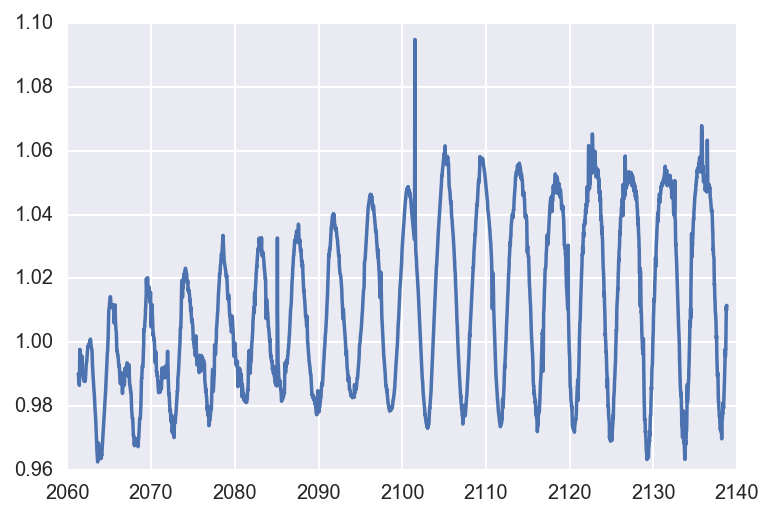

In [123]:
plt.plot(lc.time, lc.flux);

In [124]:
mt_periods, mt_values = top_N_periods(periods, P_M, n=5)

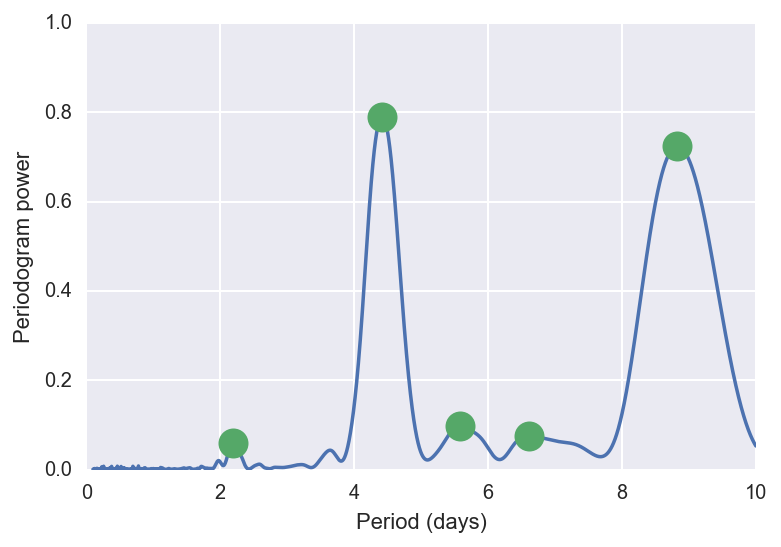

In [125]:
plt.plot(periods, P_M)
plt.plot(mt_periods, mt_values, 'o', ms=15)
plt.xlabel('Period (days)')
plt.ylabel('Periodogram power')
plt.ylim(0, 1);

## Loop it

The progress bar in astropy will help us track the computation progress:

In [97]:
from astropy.utils.console import ProgressBar

Let's just take half the number of available sources to make the computation finish in 1 hour.

In [93]:
N_subset = 829 

The following commands will select the top 5 periods for each object's light curve.

In [94]:
df_out = pd.DataFrame()
with ProgressBar(N_subset, ipython_widget=True) as bar:
    for i in k2_c2.index.values[0:N_subset]:
        bar.update()

        # Get the lightcurve
        df_out.set_value(i, 'EPIC_ID', k2_c2.EPIC_ID[i])
        lc = light_curve_data(k2_c2.EPIC_ID[i])

        # Compute Lomb-Scargle power
        periods, P_M, P_LS = run_periodograms(lc)

        # Get the top 5 periods
        nn = 5
        mt_periods, mt_values = top_N_periods(periods, P_M, n=nn)
        ls_periods, ls_values = top_N_periods(periods, P_LS,n=nn)

        # Save to a massive dataframe
        for j in range(nn):
            df_out.set_value(i, 'top_MT_val{:02d}'.format(j), mt_values[j])
            df_out.set_value(i, 'top_MT_per{:02d}'.format(j), mt_periods[j])
            df_out.set_value(i, 'top_LS_val{:02d}'.format(j), ls_values[j])
            df_out.set_value(i, 'top_LS_per{:02d}'.format(j), ls_periods[j])

The computation on 829 sources took about 1 hour.

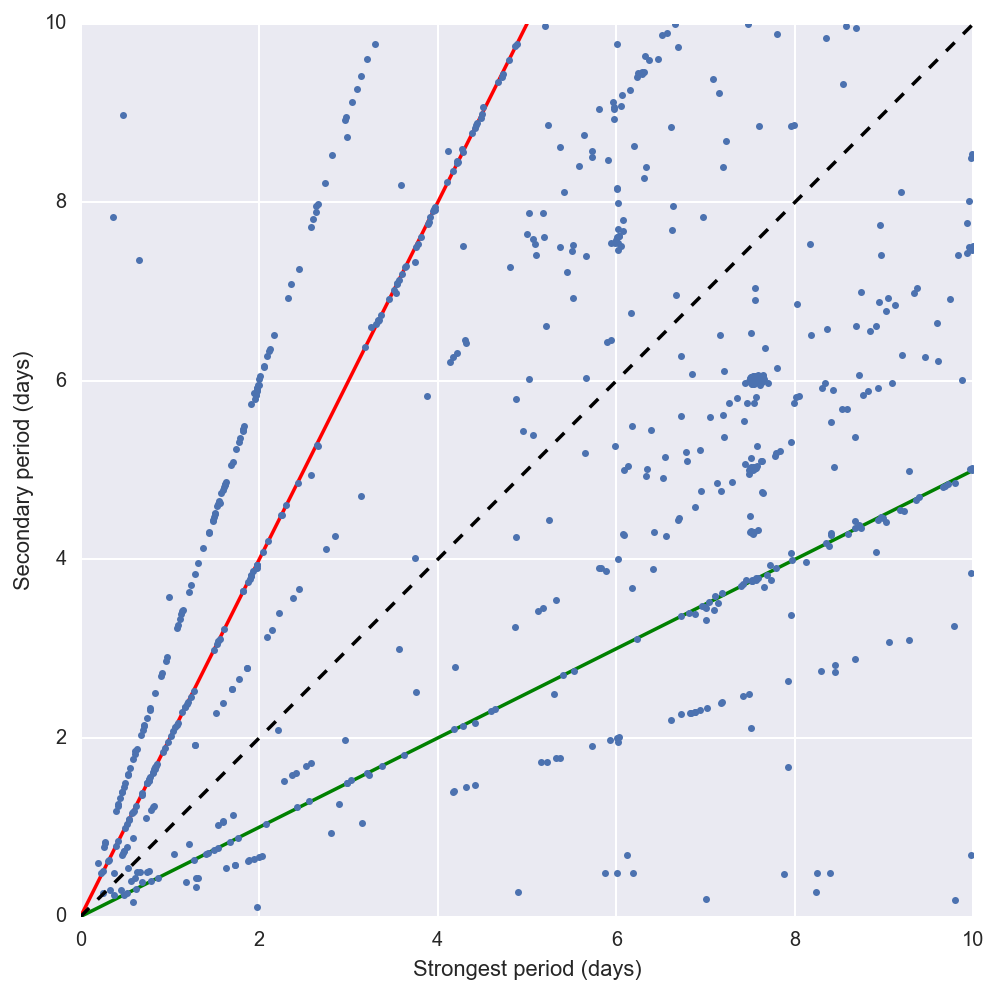

In [142]:
plt.figure(figsize=(8, 8))
plt.plot([0, 10], [0, 20], 'r-')
plt.plot([0, 20], [0, 10], 'g-')
plt.plot(df_out.top_MT_per00, df_out.top_MT_per01, '.')
plt.plot([0, 10], [0, 10], 'k--')
plt.ylim(0, 10)
plt.xlim(0, 10)
plt.xlabel("Strongest period (days)")
plt.ylabel("Secondary period (days)");

Awesome!!!